# Run Correlation-Based Analyses

### Authors: Calvin Howard.

#### Last updated: July 6, 2023

Use this to assess if a correlation between a dependent variable and an independent variable is statistically significant using permutation analysis. 

Further, follow this up with a contrast analysis which sees which categorical variables have significantly different correlations from each other. 

Notes:
- To best use this notebook, you should be familar with mixed effects models

# 00 - Import CSV with All Data
**The CSV is expected to be in this format**
- ID and absolute paths to niftis are critical
```
+-----+----------------------------+--------------+--------------+--------------+
| ID  | Nifti_File_Path            | Covariate_1  | Covariate_2  | Covariate_3  |
+-----+----------------------------+--------------+--------------+--------------+
| 1   | /path/to/file1.nii.gz      | 0.5          | 1.2          | 3.4          |
| 2   | /path/to/file2.nii.gz      | 0.7          | 1.4          | 3.1          |
| 3   | /path/to/file3.nii.gz      | 0.6          | 1.5          | 3.5          |
| 4   | /path/to/file4.nii.gz      | 0.9          | 1.1          | 3.2          |
| ... | ...                        | ...          | ...          | ...          |
+-----+----------------------------+--------------+--------------+--------------+
```

In [ ]:
# Specify the path to your CSV file containing NIFTI paths
input_csv_path = '/Users/cu135/Dropbox (Partners HealthCare)/studies/cognition_2023/metadata/master_list_proper_subjects.xlsx'

In [ ]:
# Specify where you want to save your results to
out_dir = '/Users/cu135/Library/CloudStorage/OneDrive-Personal/OneDrive_Documents/Research/2023/subiculum_cognition_and_age/figures/Figures/supplements/age_does_not_crr_with_conn'

In [ ]:
from calvin_utils.permutation_analysis_utils.statsmodels_palm import CalvinStatsmodelsPalm
# Instantiate the PalmPrepararation class
cal_palm = CalvinStatsmodelsPalm(input_csv_path=input_csv_path, output_dir=out_dir, sheet='master_list_proper_subjects')
# Call the process_nifti_paths method
data_df = cal_palm.read_and_display_data()



# 01 - Preprocess Your Data

**Handle NANs**
- Set drop_nans=True is you would like to remove NaNs from data
- Provide a column name or a list of column names to remove NaNs from

In [ ]:
data_df.columns

In [ ]:
drop_list = ['Z_Scored_Percent_Cognitive_Improvement', 'Subiculum_Connectivity_T', 'Age']

In [ ]:
data_df = cal_palm.drop_nans_from_columns(columns_to_drop_from=drop_list)
display(data_df)

**Drop Row Based on Value of Column**

Define the column, condition, and value for dropping rows
- column = 'your_column_name'
- condition = 'above'  # Options: 'equal', 'above', 'below'

Set the parameters for dropping rows

In [ ]:
column = 'City'  # The column you'd like to evaluate
condition = 'equal'  # Thecondition to check ('equal', 'above', 'below', 'not')
value = 'Boston' # The value to compare against

In [ ]:
data_df, other_df = cal_palm.drop_rows_based_on_value(column, condition, value)
data_df

**Standardize Data**
- Enter Columns you Don't want to standardize into a list

In [ ]:
# Remove anything you don't want to standardize
cols_not_to_standardize = ['Age',  'Subiculum_Connectivity_T']

In [ ]:
data_df = cal_palm.standardize_columns(cols_not_to_standardize)
data_df

In [ ]:
data_df.describe()

Miscellaneous Configurations

In [ ]:
data_df.columns

In [ ]:
list_values = ['MTLSurface', 'MTLGM', 'MTLWM']

In [ ]:
[listval for listval in list_values]

In [ ]:
# Assuming data_df is your DataFrame
for column in data_df.columns:
    for val in list_values:
        if val == column:
            data_df[column] = data_df[column] * -1


# 02 - Perform Basic Correlation

In [ ]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr, kendalltau

class ScatterplotGenerator:
    def __init__(self, dataframe, data_dict, x_label='xlabel', y_label='ylabel', correlation='pearson', palette='tab10', out_dir=None, rows_per_fig=2, cols_per_fig=3, ylim=None):
        self.dataframe = dataframe
        self.data_dict = data_dict
        self.x_label = x_label
        self.y_label = y_label
        self.correlation = correlation
        self.out_dir = out_dir if out_dir else 'scatterplot_figures'
        self.palette = palette
        self.rows_per_fig = rows_per_fig
        self.cols_per_fig = cols_per_fig
        self.figures = []
        self.ylim=ylim

    def set_palette(self):
        sns.set_style('white')
        if isinstance(self.palette, str) and self.palette.startswith('#'):
            sns.set_palette(sns.color_palette([self.palette]))
        else:
            sns.set_palette(self.palette, 1, desat=1)

    def plot_scatter_with_kde(self):
        fig, axes = plt.subplots(self.rows_per_fig, self.cols_per_fig, figsize=(self.cols_per_fig * 5, self.rows_per_fig * 5))
        axes = axes.flatten()
        current_ax = 0

        for dependent_var, independent_vars in self.data_dict.items():
            self.dependent_var=dependent_var
            for independent_var in independent_vars:
                if current_ax >= len(axes):
                    self.figures.append(fig)
                    fig, axes = plt.subplots(self.rows_per_fig, self.cols_per_fig, figsize=(self.cols_per_fig * 5, self.rows_per_fig * 5))
                    axes = axes.flatten()
                    current_ax = 0

                sns.regplot(x=independent_var, y=dependent_var, data=self.dataframe, ax=axes[current_ax])

                if self.correlation == 'pearson':
                    r, p = pearsonr(self.dataframe[independent_var], self.dataframe[dependent_var])
                elif self.correlation == 'spearman':
                    r, p = spearmanr(self.dataframe[independent_var], self.dataframe[dependent_var])
                elif self.correlation == 'kendall':
                    r, p = kendalltau(self.dataframe[independent_var], self.dataframe[dependent_var])
                else:
                    raise ValueError(f'Correlation {self.correlation} not specified, please select "pearson", "kendall" or "spearman"')
                
                if self.ylim is not None:
                    axes[current_ax].set_ylim(self.ylim[0], self.ylim[1])
                
                axes[current_ax].set_title(independent_var)
                axes[current_ax].annotate(f"{self.correlation.capitalize()} r = {r:.2f}, p = {p:.3f}", xy=(.05, .95), xycoords='axes fraction', horizontalalignment='left', verticalalignment='top')
                axes[current_ax].set_xlabel(self.x_label)
                axes[current_ax].set_ylabel(self.y_label)

                current_ax += 1

        self.figures.append(fig)  # Append the last figure

    def save_plots(self):
        if self.out_dir:
            os.makedirs(self.out_dir, exist_ok=True)
            for i, fig in enumerate(self.figures):
                fig.savefig(os.path.join(self.out_dir, f'{self.dependent_var}{i}.png'))
                fig.savefig(os.path.join(self.out_dir, f'{self.dependent_var}{i}.svg'))
                print(f'Figure saved to: {os.path.join(self.out_dir, f"{self.dependent_var}{i}")}')
                plt.show()

    def run(self):
        self.set_palette()
        self.plot_scatter_with_kde()
        self.save_plots()


Define Variables to Correlate
- 

Variables to Correlate
- dependent_variable = 'Z_Scored_Percent_Cognitive_Improvement'
- independent_variable_list = ['Z_Scored_Cognitive_Baseline']


In [ ]:
data_df.columns

In [ ]:
dependent_variable = 'Age'
independent_variable_list = ['Subiculum_Connectivity_T', 'Memory_Network_T']

Choose Correlation Method
- Options: 'spearman', 'pearson', 'kendall'

In [ ]:
correlation = 'pearson'

Define plot Labels
- These are the axes

In [ ]:
# Axis Labels
x_label = 'Connectivity'
y_label = 'Z-Scored Cognitive Improvement (MDRS)'

Run the Correlation

In [ ]:
# Usage Example
generator = ScatterplotGenerator(dataframe=data_df, data_dict={dependent_variable: independent_variable_list}, 
                                 x_label=x_label, y_label=y_label, correlation=correlation, 
                                 out_dir=out_dir, palette='Blues',
                                 rows_per_fig=1, cols_per_fig=2,
                                 ylim=None)
generator.run()

Run for a Bunch of Dependent Variables

In [ ]:
dep_vars = ['Subiculum_Connectivity_T', 'Memory_Network_T']
independent_variable_list = ['Age']

In [ ]:
for dep_var in dep_vars:
    generator = ScatterplotGenerator(dataframe=data_df, data_dict={dep_var: independent_variable_list}, 
                                 x_label=x_label, y_label=dep_var, correlation=correlation, 
                                 out_dir=out_dir, palette='Blues',
                                 rows_per_fig=1, cols_per_fig=2,
                                 ylim=None)
    generator.run()

# 03 - Run ANCOVA-Style Analysis Using Correlation
- AKA a 'Delta-R Analysis'

In [26]:
from statannotations.Annotator import Annotator
import pandas as pd
import numpy as np
from tqdm import tqdm
import itertools
import random
import matplotlib.pyplot as plt
import seaborn as sns

class ANCOVACorrelation:
    """
    Params:
        similarity: Bool
            - This determins if the delta-r analysis will be performed to assess if the correlations are MORE SIMILAR THAN EXPECTED.
            - Defaults to False, which evalutes if they are MORE DIFFERENCE THAN EXPECTED. 
        two_tail: Bool
            - This determines if a two-tailed p-value derivation will be performed. 
            - Set to false to generate a one-tail. 
    """
    def __init__(self, df, dependent_variable, independent_variable, categorical_variable, spearman=False, out_dir=None, n_permutations=10000, similarity=False, two_tail=True):
        self.df = df
        self.dependent_variable = dependent_variable
        self.independent_variable = independent_variable
        self.categorical_variable = categorical_variable
        self.out_dir = out_dir
        self.similarity = similarity
        self.two_tail = two_tail
        # Initialize a dictionary to store dataframes for each category
        self.category_dataframes = {}
        
        # Initialize a dictionary to store observed correlations
        self.observed_correlations = {}
        
        # Call the segregator function to split the data
        self.segregate_data()
        self.spearman=spearman
        
        self.n_permutations=n_permutations
    
    def segregate_data(self):
        # Group the data by unique values of the categorical variable
        unique_categories = self.df[self.categorical_variable].unique()
        
        # Create separate dataframes for each category
        for category in unique_categories:
            self.category_dataframes[category] = self.df[self.df[self.categorical_variable] == category]
    
    def calculate_correlation(self, category):
        # Calculate the correlation between independent and dependent variables for a given category
        category_df = self.category_dataframes.get(category)
        if category_df is not None:
            if self.spearman:
                correlation = category_df[self.independent_variable].corr(category_df[self.dependent_variable], method='spearman')
            else:
                correlation = category_df[self.independent_variable].corr(category_df[self.dependent_variable])
            self.observed_correlations[category] = correlation
        else:
            print(f"Category '{category}' not found in the data.")

            
    def calculate_observed_r_values(self):
        # Calculate observed r values for each category and store them
        self.observed_correlations = {}
        for category in self.category_dataframes.keys():
            correlation = self.calculate_correlation(category)
            if correlation is not None:
                self.observed_correlations[category] = correlation

    def permute_and_calculate_correlations(self):
        # Initialize a dictionary to store permuted correlations for each category
        self.permuted_correlations = {category: [] for category in self.category_dataframes.keys()}

        for _ in tqdm(range(self.n_permutations), desc="Permutations"):
            # Create a copy of the original data to permute
            permuted_data = self.df.copy()

            # Loop through each category's dataframe
            for category, category_df in self.category_dataframes.items():
                # Permute the outcomes (dependent variable) within the category's dataframe
                category_outcomes = category_df[self.dependent_variable].values
                random.shuffle(category_outcomes)
                permuted_data.loc[category_df.index, self.dependent_variable] = category_outcomes

                # Calculate and store the correlation with the independent variable
                correlation = category_df[self.independent_variable].corr(permuted_data.loc[category_df.index, self.dependent_variable])
                self.permuted_correlations[category].append(correlation)
                
    def calculate_p_values(self):
        '''
        This calculate a two-tailed p-value.
        '''
        # Initialize a dictionary to store p-values for each category
        self.p_values = {category: None for category in self.category_dataframes.keys()}

        for category in self.category_dataframes.keys():
            observed_val = self.observed_correlations[category]
            permuted_dist = self.permuted_correlations[category]

            # Calculate the p-value
            p_value = np.mean(np.array(np.abs(permuted_dist)) > np.abs(observed_val))

            self.p_values[category] = p_value
            
    def calculate_delta_r(self):
        # Initialize a dictionary to store Delta-R values and their significance for each category combination
        self.delta_r_values = {}
        
        # Get all unique combinations of categories
        category_combinations = list(itertools.combinations(self.category_dataframes.keys(), 2))

        for category1, category2 in category_combinations:
            observed_val1 = self.observed_correlations[category1]
            observed_val2 = self.observed_correlations[category2]

            # Get the permuted distributions for both categories
            permuted_dist1 = self.permuted_correlations[category1]
            permuted_dist2 = self.permuted_correlations[category2]

            delta_r = observed_val1 - observed_val2
            delta_r_permuted = np.array(permuted_dist1) - np.array(permuted_dist2)

            # Calculate the significance using a two-tailed test
            if self.two_tail:
                delta_r = np.abs(delta_r)
                delta_r_permuted = np.abs(delta_r_permuted)
            if self.similarity:
                p_value = np.mean(delta_r_permuted < delta_r)
            else:
                p_value = np.mean(delta_r_permuted > delta_r)
            # Store the Delta-R value and its significance
            self.delta_r_values[(category1, category2)] = {
                'delta_r': delta_r,
                'p_value': p_value
            }

    def plot_correlations(self):
        # Convert observed correlations data to a DataFrame
        observed_data = pd.DataFrame({
            'Category': self.observed_correlations.keys(),
            'Correlation': self.observed_correlations.values()
        })

        # Set style and increase font size
        sns.set_style("white")
        # sns.set(font_scale=1)

        # Create the bar plot using the observed data
        sns.barplot(x='Category', y='Correlation', data=observed_data, palette='tab10')
        sns.despine()
        # # Add p-value annotations using Annotator
        p_values = [self.delta_r_values[comb]['p_value'] for comb in self.delta_r_values]
        combinations = [f'{comb[0]} vs {comb[1]}' for comb in self.delta_r_values]
        data = pd.DataFrame({'Combination': combinations, 'p-value': p_values})
        # annotator = Annotator(ax=ax, data=data, x='Combination', y='p-value', loc='outside', fontsize=12)

        # Save the figure if out_dir is provided
        if self.out_dir:
            plt.savefig(f"{self.out_dir}/delta_correlation_plot.png", bbox_inches='tight')
            plt.savefig(f"{self.out_dir}/delta_correlation_plot.svg", bbox_inches='tight')
            print(f'Saved to {self.out_dir}/delta_correlation_plot.svg')

        # Show the plot
        plt.show()
        return observed_data, data
        
    def run(self):
        self.segregate_data()
        self.calculate_observed_r_values()
        self.permute_and_calculate_correlations()
        self.calculate_p_values()
        self.calculate_delta_r()
        single_data, delta_data = self.plot_correlations()
        return single_data, delta_data

    def create_combined_plot(self, group_variable, dependent_variable):
        sns.set()

        fig, ax = plt.subplots(nrows=len(self.df[group_variable].unique()), sharex=True)
        ax[-1].set_xlabel(dependent_variable)

        for i, group_val in enumerate(self.df[group_variable].unique()):
            group_data = self.df[self.df[group_variable] == group_val][dependent_variable]
            jittered_group_data = group_data + 0.1 * (2 * random.random() - 1)  # Add small vertical jitter
            ax[i].scatter(jittered_group_data, [0] * len(group_data))
            sns.kdeplot(group_data, ax=ax[i], shade=False, legend=False)
            ax[i].set_yticks([])
            ax[i].set_ylim(-0.01)
            ax[i].set_ylabel(f'{group_variable} ' + str(group_val))

        plt.show()
        
    def plot_correlations_with_lmplot(self, palette='Tab10'):
        # Using seaborn's lmplot to plot linear regression lines for each category
        if self.spearman:
            print('Have rank-transformed data for visualization of Spearman correlation.')
            self.df = self.df.rank()
        lm = sns.lmplot(x=self.independent_variable, y=self.dependent_variable, 
                        hue=self.categorical_variable, data=self.df, 
                        aspect=1.5, height=5, palette=palette, legend=False, ci=0)

        # Enhancements for better readability
        lm.set_xlabels(f"{self.independent_variable}")
        lm.set_ylabels(f"{self.dependent_variable}")
        plt.title("Correlation Split by Category")
        plt.legend()
        # Save the figure if out_dir is provided
        if self.out_dir:
            plt.savefig(f"{self.out_dir}/delta_correlation_plot.png", bbox_inches='tight')
            plt.savefig(f"{self.out_dir}/delta_correlation_plot.svg", bbox_inches='tight')
            print(f'Saved to {self.out_dir}/delta_correlation_plot.svg')
        plt.show()

In [22]:
data_df.columns

Index(['subject', 'Age', 'Normalized_Percent_Cognitive_Improvement',
       'Z_Scored_Percent_Cognitive_Improvement_By_Origin_Group',
       'Z_Scored_Percent_Cognitive_Improvement',
       'Percent_Cognitive_Improvement',
       'Z_Scored_Subiculum_T_By_Origin_Group_',
       'Z_Scored_Subiculum_Connectivity_T', 'Subiculum_Connectivity_T',
       'Amnesia_Lesion_T_Map', 'Memory_Network_T', 'Z_Scored_Memory_Network_R',
       'Memory_Network_R', 'Subiculum_Grey_Matter', 'Subiculum_White_Matter',
       'Subiculum_CSF', 'Subiculum_Total', 'Standardized_Age',
       'Standardized_Percent_Improvement',
       'Standardized_Subiculum_Connectivity',
       'Standardized_Subiculum_Grey_Matter',
       'Standardized_Subiculum_White_Matter', 'Standardized_Subiculum_CSF',
       'Standardized_Subiculum_Total', 'Disease', 'Cohort', 'City',
       'Inclusion_Cohort', 'Age_Group', 'Age_And_Disease',
       'Age_Disease_and_Cohort', 'Subiculum_Group_By_Z_Score_Sign',
       'Subiculum_Group_By_Infl

Enter Variables
- dependent_variable: the name of the dependent variable
- independent_variable: the name of the independent variable
- categorical_variable: the column containing categorical information. This may be strings or numbers. 

In [ ]:
data_df.columns

In [23]:
dependent_variable = 'Z_Scored_Percent_Cognitive_Improvement'
independent_variable = 'Subiculum_Connectivity_T'
categorical_variable = 'Age_Disease_and_Cohort'

Do You Want to Run A Spearman Correlation?

In [28]:
spearman = False
two_tail = False
similarity = True

# 04 - Run the Correlational ANCOVA

Permutations: 100%|██████████| 10000/10000 [00:28<00:00, 356.35it/s]


Saved to /Users/cu135/Library/CloudStorage/OneDrive-Personal/OneDrive_Documents/Research/2023/subiculum_cognition_and_age/figures/Figures/supplements/age_does_not_crr_with_conn/delta_correlation_plot.svg


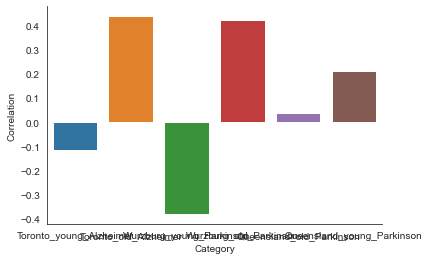

,Combination,p-value
0,Toronto_young_Alzheimer vs Toronto_old_Alzheimer,0.0481
1,Toronto_young_Alzheimer vs Wurzburg_young_Park...,0.7651
2,Toronto_young_Alzheimer vs Wurzburg_old_Parkinson,0.3084
3,Toronto_young_Alzheimer vs Queensland_old_Park...,0.3197
4,Toronto_young_Alzheimer vs Queensland_young_Pa...,0.1675
5,Toronto_old_Alzheimer vs Wurzburg_young_Parkinson,0.9979
6,Toronto_old_Alzheimer vs Wurzburg_old_Parkinson,0.4997
7,Toronto_old_Alzheimer vs Queensland_old_Parkinson,0.9363
8,Toronto_old_Alzheimer vs Queensland_young_Park...,0.8002
9,Wurzburg_young_Parkinson vs Wurzburg_old_Parki...,0.1717


In [29]:
delta_r = ANCOVACorrelation(df=data_df, dependent_variable=dependent_variable, independent_variable=independent_variable, categorical_variable=categorical_variable, out_dir=out_dir, spearman=spearman,
                            n_permutations=10000, similarity=similarity, two_tail=two_tail)
single_data, delta_data = delta_r.run()
delta_data

Save the Output CSV

In [ ]:
import os
print(os.path.join(out_dir, 'vent.csv'))
delta_data.to_csv(os.path.join(out_dir, 'vent.csv'))

Visualize Scatter

In [ ]:
delta_r.plot_correlations_with_lmplot(palette='Set1')

In [ ]:
single_data

# 05 - Delta Scatterplot (Pretty)

In [ ]:
# Redefining the class and its methods
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t
import seaborn as sns
class ScatterWithConfidence:
    def __init__(self, data_df):
        self.data_df = data_df

    @staticmethod
    def compute_analytic_confidence_interval(x, y, x_vals):
        slope, intercept = np.polyfit(x, y, 1)
        y_fit = slope * x_vals + intercept
        
        residuals = y - (slope * x + intercept)
        stderr = np.sqrt(np.sum(residuals**2) / (len(y) - 2))
        
        t_value = t.ppf(0.975, df=len(x)-2)
        ci = t_value * stderr * np.sqrt(1/len(x) + (x_vals - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
        
        upper_bound = y_fit + ci
        lower_bound = y_fit - ci
        
        return y_fit, lower_bound, upper_bound

    def permute_data_and_difference_in_pearson_r(self, x_one, x_two, split_by, split_value, n_permutations=1000, permute_columns=[]):
        original_diff = self.data_df[self.data_df[split_by] < split_value][x_one].corr(self.data_df[self.data_df[split_by] < split_value][x_two]) - \
                       self.data_df[self.data_df[split_by] >= split_value][x_one].corr(self.data_df[self.data_df[split_by] >= split_value][x_two])

        permuted_diffs = []

        for _ in range(n_permutations):
            permuted_df = self.data_df.copy()
            for column in permute_columns:
                permuted_df[column] = np.random.permutation(permuted_df[column].values)
            
            diff = permuted_df[permuted_df[split_by] < split_value][x_one].corr(permuted_df[permuted_df[split_by] < split_value][x_two]) - \
                   permuted_df[permuted_df[split_by] >= split_value][x_one].corr(permuted_df[permuted_df[split_by] >= split_value][x_two])
            
            permuted_diffs.append(diff)

        p_value = np.mean([diff <= original_diff for diff in permuted_diffs])
        return original_diff, p_value

    def plot_with_analytic_ci_manual_pvalue(self, x_one, x_two, 
                                            split_by, split_value, 
                                            x_label='X1', y_label='X2', 
                                            upper_split_legend='Above Split', lower_split_legend='Below Split',
                                            alpha=0.3, manual_p_value=None, permute_column=None, 
                                            save=False, out_dir=None,
                                            colour1='red', colour2='blue'):
        fig, ax = plt.subplots(figsize=(6, 5))
        
        group1 = self.data_df[self.data_df[split_by] < split_value]
        group2 = self.data_df[self.data_df[split_by] >= split_value]

        ax.scatter(group1[x_one], group1[x_two], color=colour1, label=lower_split_legend, s=40, alpha=alpha, marker='o')
        ax.scatter(group2[x_one], group2[x_two], color=colour2, label=upper_split_legend, s=40, alpha=alpha, marker='o')
        
        x_vals = np.linspace(self.data_df[x_one].min(), self.data_df[x_one].max(), 400)
        
        for group, color in [(group1, colour1), (group2, colour2)]:
            y_fit, lower_bound, upper_bound = self.compute_analytic_confidence_interval(group[x_one], group[x_two], x_vals)
            ax.plot(x_vals, y_fit, color=color)
            # ax.fill_between(x_vals, lower_bound, upper_bound, color=color, alpha=alpha/4)
        
        if manual_p_value is None:
            if permute_column:
                rho, manual_p_value = self.permute_data_and_difference_in_pearson_r(x_one, x_two, split_by, split_value, n_permutations=10000, permute_columns=[permute_column])
            else:
                rho, manual_p_value = self.permute_data_and_difference_in_pearson_r(x_one, x_two, split_by, split_value, n_permutations=10000, permute_columns=[x_one, x_two, split_by])
        
        ax.set_title(f"\u0394 r = {rho:.2f} , p = {manual_p_value:.4f}")
        ax.set_ylabel(y_label)
        ax.set_xlabel(x_label)
        ax.legend(loc='best', frameon=False)
        ax.grid(False)
        sns.despine(ax=ax)
        
        if save and out_dir is not None:
            plt.savefig(f"{out_dir}/scatter_with_polyfit_and_analytic_ci.png", bbox_inches='tight')
            plt.savefig(f"{out_dir}/scatter_with_polyfit_and_analytic_ci.svg", bbox_inches='tight')
            print(f'Saved to {out_dir}/scatter_with_polyfit_and_analytic_ci.svg')
        return fig
    
class DeltaCorrelation(ScatterWithConfidence):
    def __init__(self, data_df):
        super().__init__(data_df)

    def plot_histogram_of_delta_r(self, x_one, x_two, split_by, split_value, n_permutations=1000, 
                                permute_columns=[], bins=50, one_tail=False, color_palette='dark'):
        # Generate the empirical distribution of delta_r
        delta_rs = []
        for _ in range(n_permutations):
            permuted_df = self.data_df.copy()
            for column in permute_columns:
                permuted_df[column] = np.random.permutation(permuted_df[column].values)

            delta_r = permuted_df[permuted_df[split_by] < split_value][x_one].corr(permuted_df[permuted_df[split_by] < split_value][x_two]) - \
                    permuted_df[permuted_df[split_by] >= split_value][x_one].corr(permuted_df[permuted_df[split_by] >= split_value][x_two])
            delta_rs.append(delta_r)

        # Calculate the observed delta_r
        observed_delta_r, _ = self.permute_data_and_difference_in_pearson_r(x_one, x_two, split_by, split_value, permute_columns=permute_columns)

        if one_tail:
            observed_delta_r = np.abs(observed_delta_r)
            delta_rs = np.abs(delta_rs)

        # Calculate p-value
        if one_tail:
            p_value = np.mean([delta_r >= observed_delta_r for delta_r in delta_rs])
        else:
            p_value = np.mean([delta_r <= observed_delta_r for delta_r in delta_rs])

        # Generate the displot (KDE + Histogram) using Seaborn
        sns.set_palette(color_palette)
        current_palette = sns.color_palette(color_palette)
        chosen_color = current_palette[4]
        plt.figure(figsize=(6, 5))
        g = sns.displot(delta_rs, kde=True, bins=bins, label="Empirical $\\Delta r$ Distribution", element="step",color='blue', alpha=.6)
        plt.axvline(x=observed_delta_r, color='red', linestyle='-', linewidth=1.5, label=f"Observed $\\Delta r$", alpha=0.6)
        plt.title(f"$\\Delta r$ = {observed_delta_r}, p = {p_value}")
        plt.xlabel("$\\Delta r$")
        plt.ylabel("Count")
        plt.legend()
        
        fig = g.fig
        
        fig.savefig(f"{out_dir}/hist_kde.png", bbox_inches='tight')
        fig.savefig(f"{out_dir}/hist_kde.svg", bbox_inches='tight')
        print(f'Saved to {out_dir}/hist_kde.svg')
    


In [ ]:
data_df.columns

In [ ]:
data_df = data_df.loc[:, ['TOTAL11', 'CerebellumSBM',
       'CerebellumCSF', 'CerebellumGM', 'CerebellumWM', 'FrontalSurface',
       'FrontalCSF', 'FrontalGM', 'FrontalWM', 'MTLCSF', 'MTLGM', 'MTLWM',
       'OccipitalSurface', 'OccipitalCSF', 'OccipitalGM', 'OccipitalWM',
       'ParietalSurface', 'ParietalCSF', 'ParietalGM', 'ParietalWM',
       'SubcortexSurfaceVentricle', 'SubcortexCSF',
       'SubcortexGM', 'SubcortexWM', 'temp_ins_csf', 'temp_ins_gm',
       'temp_ins_wm', 'temp_ins_surface']]

Data To Plot

In [ ]:
# Data Variables
dependent_variable = 'Z_Scored_Percent_Cognitive_Improvement'
independent_variable = 'Z_Scored_Subiculum_Connectivity'
split_by_var = 'Cohort' # This is the column which contains the values you are going to split the data by 
split_value_var = 1.5 # This is the value which will be used to determine how rows of the given column split the entire dataset

Labels for Plot

In [ ]:
# Plotting Variables
x_label = 'Standardized Subiculum Connectivity'
y_label = 'Standardized Percent Improvement'
legend_string_for_lower_split='Alzheimer Disease'
legend_string_for_upper_split='Parkinson Disease'

In [ ]:
delta_sctr = ScatterWithConfidence(data_df)
delta_sctr_plot = delta_sctr.plot_with_analytic_ci_manual_pvalue(
                                            x_one=independent_variable, x_two=dependent_variable,
                                            split_by=split_by_var, split_value=split_value_var,
                                            x_label=x_label, y_label=y_label,
                                            upper_split_legend=legend_string_for_upper_split, lower_split_legend=legend_string_for_lower_split,
                                            alpha=0.3, manual_p_value=None, permute_column=None,
                                            save=True, out_dir=out_dir,
                                            colour1='#FF0000', colour2='#0000FF')

In [ ]:
# Create an object from the new Seaborn-based class
histogram_plotter_seaborn = DeltaCorrelation(data_df)

# Generate the histogram using Seaborn
fig = histogram_plotter_seaborn.plot_histogram_of_delta_r(x_one=independent_variable, x_two=dependent_variable, 
                                                    split_by=split_by_var, split_value=split_value_var, 
                                                    n_permutations=10000, 
                                                    permute_columns=[independent_variable, dependent_variable, split_by_var], 
                                                    bins=50,
                                                    one_tail=True, 
                                                    color_palette='coolwarm')

# Correlation Matrix and Heatmap

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation_heatmap(dataframe):
    # Calculate the correlation matrix
    corr_matrix = dataframe.corr()

    # Create a heatmap
    plt.figure(figsize=(20, 16))
    sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={'shrink': .5})

    # Adjust the layout
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.title('Correlation Heatmap')

    # Show the plot
    plt.show()


In [ ]:
# Example usage
sorted_columns = sorted(data_df.columns)
data_df_sorted = data_df[sorted_columns]
plot_correlation_heatmap(data_df)

# Canonical Correlation

In [ ]:
from sklearn.cross_decomposition import CCA

def perform_cca(data_df, set1_columns, set2_columns):
    """
    Perform Canonical Correlation Analysis (CCA) between two sets of columns in a DataFrame.

    Parameters:
        data_df (pd.DataFrame): The DataFrame containing the data.
        set1_columns (list): List of column names for the first set of variables.
        set2_columns (list): List of column names for the second set of variables.

    Returns:
        cca (CCA): The CCA model object.
        cca_results (dict): A dictionary containing the CCA results.
    """
    # Extract the specified sets of columns from the DataFrame
    set1_data = data_df[set1_columns]
    set2_data = data_df[set2_columns]

    # Initialize the CCA model
    cca = CCA(n_components=min(len(set1_columns), len(set2_columns)))

    # Fit the CCA model to the data
    cca.fit(set1_data, set2_data)

    # Transform the data using CCA
    set1_transformed, set2_transformed = cca.transform(set1_data, set2_data)

    # Calculate canonical correlations from singular values
    canonical_correlations = cca.singular_values_

    # Store the CCA results in a dictionary
    cca_results = {
        'Canonical Correlations': canonical_correlations,
        'Set 1 Transformed': set1_transformed,
        'Set 2 Transformed': set2_transformed
    }

    return cca, cca_results

define 2 lists
- 1 is the first set to CCA
- 2 is the second set to CCA

In [ ]:
data_df.columns

In [ ]:
templist = []
for val in data_df.columns:
    if 'CSF' in val:
        templist.insert(-1, val)
print(templist)

In [ ]:
list1 = ['frontal', 'temporal', 'parietal', 'occipital',
       'cerebellum', 'Mesial_Temporal', 'ventricle']
list2 = ['frontal_eh', 'temporal_eh', 'parietal_eh',
       'occipital_eh', 'cerebellum_eh']

In [ ]:
from sklearn.cross_decomposition import CCA

def perform_cca(data_df, set1_columns, set2_columns):
    """
    Perform Canonical Correlation Analysis (CCA) between two sets of columns in a DataFrame.

    Parameters:
        data_df (pd.DataFrame): The DataFrame containing the data.
        set1_columns (list): List of column names for the first set of variables.
        set2_columns (list): List of column names for the second set of variables.

    Returns:
        cca (CCA): The CCA model object.
        cca_results (dict): A dictionary containing the CCA results.
    """
    # Extract the specified sets of columns from the DataFrame
    set1_data = data_df[set1_columns]
    set2_data = data_df[set2_columns]

    # Initialize the CCA model
    cca = CCA(n_components=min(len(set1_columns), len(set2_columns)))

    # Fit the CCA model to the data
    cca.fit(set1_data, set2_data)

    # Calculate canonical correlations using the score method
    canonical_correlations = cca.score(set1_data, set2_data)

    # Store the CCA results in a dictionary
    cca_results = {
        'Canonical Correlations': canonical_correlations
    }

    return cca, cca_results


In [ ]:
cca, cca_results = perform_cca(data_df, set1_columns=list1, set2_columns=list2)
cca_results